# Cointegrating Cryptocurrencies
This notebook is designed to explain the basics of cointegration and the methods I employ.

## Premise
If you identify correlated assets, it is possible to take advantage of their correlation by cointegrating them. Cointegration allows us to create a basket of assets that revert to the basket's mean price (i.e. creating a stationary time-series). The basket of assets are called a synthetic asset, and trading on the synthetic asset allows us to profit off correlation while hedging risks at the same time.

In [1]:
# The usual suspects
import pandas as pd
import matplotlib.pyplot as plt

# Libraries for data analysis
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS # Ordinary Least Squares
from statsmodels.tsa.stattools import adfuller # Testing for stationarity

## Assets and Data
The model is designed to trade on 4 correlated assets: Bitcoin, Ethereum, Litecoin and Bitcoin Cash.
We also use the sample data, which is a daily OHLC data dating back a year as from 9/4/23.

The data themselves are assumed to be OHLC data from Yahoo Finance of BTC-USD, ETH-USD, LTC-USD, and BCH-USD. It is possible to adjust the below code to take in other data formats. For using custom non-Yahoo data, I leave it as an exercise for the readers.

In [2]:
cryptos = ['BTCUSD', 'ETHUSD', 'LTCUSD', 'BCHUSD']

pds = [pd.read_csv('sample_data/BTC-USD.csv'), pd.read_csv('sample_data/ETH-USD.csv'), pd.read_csv('sample_data/LTC-USD.csv'), pd.read_csv('sample_data/BCH-USD.csv')]

Next we preprocess the data to prepare for analysis. Although it may introduce some bias, we only use closing data for simplicity and noise reduction.

In [3]:
def compile_close(raw_data: list) -> pd.DataFrame:
    close_data = pd.DataFrame()
    for index, crypto in enumerate(cryptos):
        close_data[crypto] = raw_data[index].pop('Adj Close')
    return close_data

only_close = compile_close(pds)

In [4]:
only_close.head()

,BTCUSD,ETHUSD,LTCUSD,BCHUSD
0,19986.712891,1577.641602,60.900894,118.137352
1,19812.371094,1617.183228,60.416405,125.668602
2,18837.667969,1561.748535,54.313061,112.500648
3,19290.324219,1629.906372,57.415901,118.645798
4,19329.833984,1635.347656,58.003258,127.144073


## Visualizing the Data
We can visualize the degree of correlation between the assets using a log-plot. This enables us to looks at the general trends and shape of the time series without getting lost in the scale.

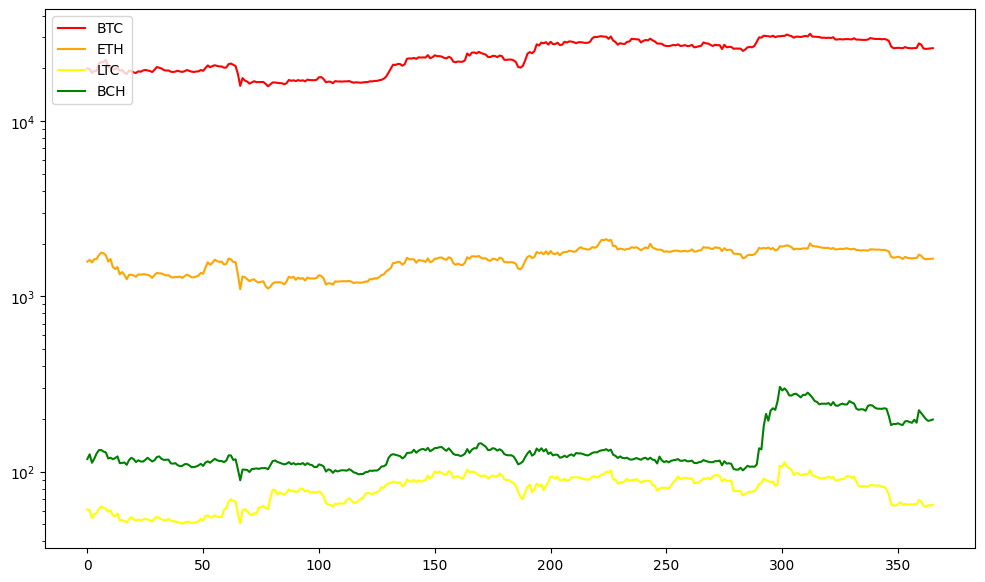

In [5]:
def log_plot(close_data):
    plt.rcParams['figure.figsize'] = (12, 7)
    plt.plot(close_data['BTCUSD'], color='red', label="BTC")
    plt.plot(close_data['ETHUSD'], color='orange', label="ETH")
    plt.plot(close_data['LTCUSD'], color='yellow', label="LTC")
    plt.plot(close_data['BCHUSD'], color='green', label="BCH")
    plt.legend(loc="upper left")
    plt.yscale('log')
    plt.show()

log_plot(only_close)

Seems like although there are some notable differences, the four graphs in general seem to have generally similar movements. We might be able to take advantage of that correlation.

## The Engle-Granger Two-Step Method
To create our mean-reverting model, we first run least squares regression. The resulting parameters are representative of the degreee of correlation between assets, and we use it as our hedge ratios. We then run augmented Dickey-Fuller test to test whether it is mean reverting.

It should be noted Engle-Granger isn't the only way to create cointegrated assets, a popular alternative being the Johansen test. I use the two-step process since it seems to create more correlated and stable models, whereas Johansen test seems to create more mean-reverting models.

In [6]:
def calculate_hedge(close_data):
    x = close_data[['ETHUSD', 'LTCUSD', 'BCHUSD']]
    x = sm.add_constant(x)
    y = close_data['BTCUSD']
    est = sm.OLS(y, x).fit()
    return list(est.params)

OLS_results = calculate_hedge(only_close)
print(f"Intercept: {OLS_results[0]}")
print(f"ETH Coefficient: {OLS_results[1]}")
print(f"LTC Coefficient: {OLS_results[2]}")
print(f"BCH Coefficient: {OLS_results[3]}")

Intercept: -5014.677471698791
ETH Coefficient: 16.416283986527308
LTC Coefficient: -2.159696797286086
BCH Coefficient: 17.34790946644853


Now that we have the hedge ratios (the hedge ratio of BTC is always 1), we can visualize it and test its stationarity.

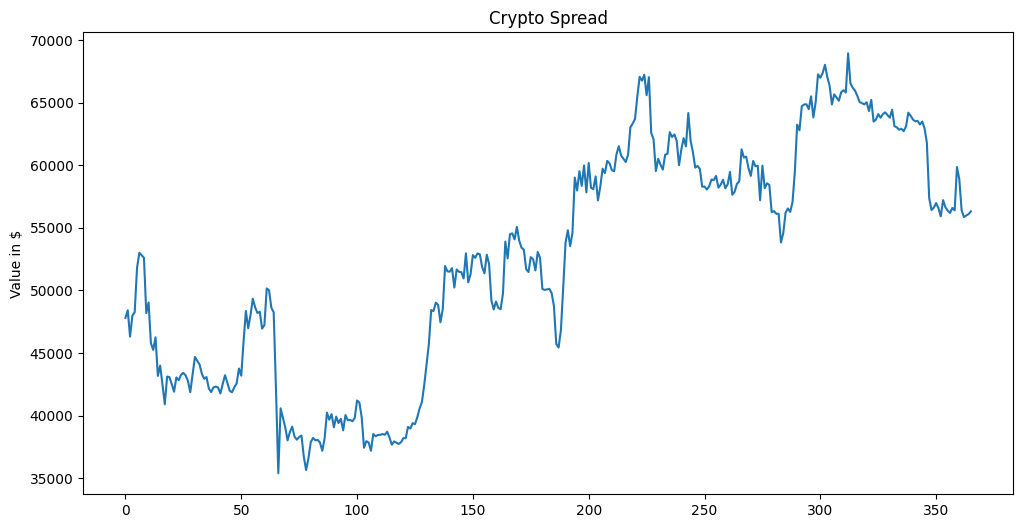

In [7]:
spread = only_close['BTCUSD'] + OLS_results[1] * only_close['ETHUSD'] + \
         OLS_results[2] * only_close['LTCUSD'] + OLS_results[3] * only_close['BCHUSD']

def show_spread(spread):
    ax = spread.plot(figsize=(12,6), title='Crypto Spread')
    ax.set_ylabel('Value in $')

show_spread(spread)

It seems the spread might have some mean reversion we could take advantage of. We can double check its stationarity using aforementioned CADF.

In [8]:
def CADF(spread):
    adf = adfuller(spread, maxlag=1)
    print(f'Critical value = {(adf[0])}')
    print(f't-values: {adf[4]}')
    print('Spread mean = %s' % (spread.mean()))
    print('Spread STD = %s' % (spread.std()))

CADF(spread)

Critical value = -1.4273681991187654
t-values: {'1%': -3.4483935212959844, '5%': -2.8694912343676497, '10%': -2.571005879151811}
Spread mean = 52587.239192682384
Spread STD = 9330.00327466275


We see that our critical value of -1.42 is greater than even the 90% confidence value. This means that our time-series (the spread) has a unit root, and therefore is not inherently stationary. However, this doesn't make the four cryptocurrencies unviable for statistical arbitrage; Even if the spread passes the CADF, there's no guarantee the spread will be be stationary over time.

## Next Steps
Now we can take the hedge ratios, spread mean, and spread standard deviation to back test on historical data. The backtest will be a better measure of how well the strategy will perform. This will not be covered in this notebook as the primary purpose of the repo is to facilitate backtesting and live trading.